In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import cartopy.feature as cfea

In [230]:
def geography():
    SUF = '.gl5'
    dtype = 'float32'
    #
    a = 2160
    b = 4320
    gl5shape = (a, b)
    #
    city_num = 1
    #
    # region
    one = 138
    two = 141
    three = 34
    four = 37
    #
    upperindex = (90-four)*12
    lowerindex = (90-three)*12
    leftindex = (180+one)*12
    rightindex = (180+two)*12
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)
    
    return a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num

In [536]:
def lonlat2xy(loncnt, latcnt):
    a, b, _, __, ___, ____, _____, _____, ______ = geography()
    
    if -180 <= loncnt <=180:
        lon_middle = int(((loncnt+180)/360)*b )
        lat_middle = int(((90-latcnt)/180)*a ) 
    else:
        lon_middle = 1e20
        lat_middle = 1e20
        
    return lon_middle, lat_middle
        
def xy2lonlat(x, y):
    a, b, _, __, ___, ____, _____, _____, ______ = geography()
    
    if 0 <= x <= b:
        loncnt = (x*360/b)-180
        latcnt = 90 - (y*180)/a
    else:
        loncnt = 1e20
        latcnt = 1e20
    
    return loncnt, latcnt
    
def draw_mask(mask_temp, pop_temp, city_index, added_density, next_density, best_masked_pop, un_pop, best_coverage, next_coords):
    # cmap
    pop_vmax = 1e5
    
    # get city lonlat
    a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()

    # crop
    mask_cropped = mask_temp[upperindex:lowerindex, leftindex:rightindex]
    
    # pop
    pop_cropped = pop_temp[upperindex:lowerindex, leftindex:rightindex]

    # delta
    delta = 360/4320
    x_left = img_extent[0]
    y_top = img_extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))
    
    # josui
    #josui_path = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/fcl_obs_/jyousui_20240109.csv"
    #josui = pd.read_csv(josui_path)
    
    # regionalize
    #josui_array = np.zeros((a, b))
    # 
    #for i in range(len(josui['lon'])):
    #    lon_middle, lat_middle = lonlat2xy(josui['lon'][i], josui['lat'][i])
    #    # missing value in csv
    #    if lon_middle >= b or lat_middle >= a:
    #        continue
    #    else:
    #        josui_array[lat_middle, lon_middle] = 1
    #        
    #josui_cropped = josui_array[upperindex:lowerindex, leftindex:rightindex]
    #josui_masked = np.ma.masked_where(josui_cropped==0, josui_cropped)

    # extent
    projection = ccrs.PlateCarree()

    # figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(img_extent)
    ax.gridlines(draw_labels=True)
    im = ax.imshow(pop_cropped,
                   origin='upper',extent=img_extent, transform=projection, cmap='gist_heat_r')
                  #vmin=0, vmax=pop_vmax
    
    seethrough = np.ma.masked_where(mask_cropped == 0, mask_cropped)
    seethrough[-1, -1] = 0
    citymask_cmap = plt.cm.colors.ListedColormap(['white', '#999999'])
    im2 = ax.imshow(seethrough,
                    origin='upper',extent=img_extent, transform=projection, cmap=citymask_cmap, alpha=0.5
                   )

    # city mask
    sotowaku_color = 'black'
    linewidth = 5
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # right

    # next grid
    next_y = 90 - (next_coords[1]+1)*delta
    next_x = (next_coords[2]+1)*delta -180
    ax.plot([next_x - delta, next_x, next_x, next_x - delta, next_x - delta], 
             [next_y, next_y, next_y + delta, next_y + delta, next_y], 
             color='blue', transform=projection, linewidth=linewidth) # right

    # 
    #josui_cmap = plt.cm.colors.ListedColormap(['white', 'blue'])
    #im3 = ax.imshow(josui_masked, origin='upper', cmap=josui_cmap, vmin=0, vmax=1, extent=img_extent,  transform=projection, zorder=3)
    #im4 = ax.scatter(josui['lon'], josui['lat'], color='green', s=5, zorder=4)
    
    # save figure
    gif_path = f'./gifs/{np.sum(mask_temp):08}.jpg'
    plt.title(f"added density: {added_density} [person/km2]\nnext density: {next_density}[person/km2]\ncover rate: {int(best_masked_pop)}/{int(un_pop)}[person]\ncover rate: {np.round(best_coverage*100,2)}[%]")
    
    #plt.savefig(gif_path)
    #fig.colorbar(im, ax=ax, orientation='horizontal')
    plt.show()

(140.08333333333331, 35.666666666666664)


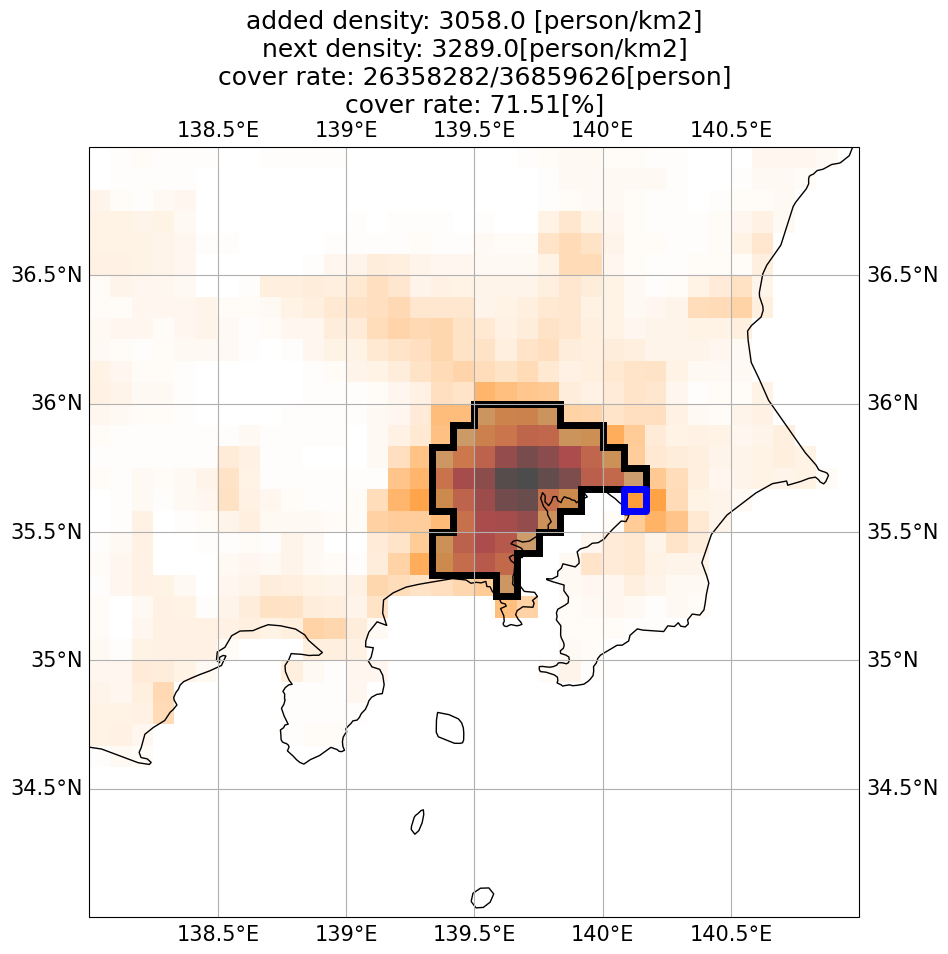

In [537]:
mask_num = 52
city_index = 1

bestmask_trace = save_dict['mask']
density_trace = save_dict['added_density']
nextdensity_trace = save_dict['next_density']
totalpop_trace = save_dict['masked_population']
coverage_trace = save_dict['cover_rate']
nextcoords_trace = save_dict['next_coords']
un_pop = save_dict['un_population']
gwp_pop_density = save_dict['population_density']

mask_tmp = bestmask_trace[:, :, mask_num-1]
prv = density_trace[mask_num-1]
nxt = nextdensity_trace[mask_num-1]
pop = totalpop_trace[mask_num-1]
cov = coverage_trace[mask_num-1]
cor = nextcoords_trace[mask_num-1]

print(xy2lonlat(3841, 652))

draw_mask(mask_tmp, gwp_pop_density, city_index, np.round(prv), np.round(nxt), pop, un_pop, cov, cor)

In [559]:
def explore_citymask(index):

    #-----------------------------------------------
    # PATHS
    #-----------------------------------------------

    # pop data
    POP='gpw4'

    # map data
    MAP='CAMA'

    # path
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    city_path = f'{h08dir}/dat/cty_lst_/{POP}/WUP2018_300k_2010.txt'
    area_path = f'{h08dir}/dat/lnd_ara_/lndara.{MAP}.gl5'
    pop_path = f'{h08dir}/dat/pop_tot_/GPW4ag__20100000.gl5'
    center_path = f'{h08dir}/dat/cty_cnt_/{POP}/city_{index:08d}.gl5'
    
    #-----------------------------------------------
    # Input Constants
    #-----------------------------------------------

    # search radius (1grid in 0.5degree = 9km)
    circle = 1

    # EN.1: lower limitation of population density
    lowlim = 100
    
    # EN.2: initial grid threshold
    threshold = 100
    
    # EN.3: grid sum
    grdlim = 3
    
    # EN.3: downtown rate
    downtown_rate = 1.5

    # EN.4: lowest rate
    lowrat = 0.0

    # shape
    lat_shape = 2160
    lon_shape = 4320

    # date type
    dtype= 'float32'

    #-----------------------------------------------
    # Initialization
    #-----------------------------------------------
    
    # initialize variables
    best_coverage = float('inf')
    best_mask = None
    best_masked_pop = None

    #-----------------------------------------------
    # load true data (UN city list) unit=[1000person]
    #-----------------------------------------------

    # true population and city name
    un_pop_list = []
    name_list = []

    # load data
    for l in open(city_path).readlines():
        data = l[:].split('\t')
        data = [item.strip() for item in data]
        un_pop_list.append(float(data[3]))
        name_list.append(data[4])

    # get true UN city population
    un_pop = un_pop_list[index-1]*1000

    # get city name
    city_name = name_list[index-1]

    #-----------------------------------------------
    #  Get area(m2)
    #-----------------------------------------------

    area = np.fromfile(area_path, dtype=dtype).reshape(lat_shape, lon_shape)

    #-----------------------------------------------
    # load gwp population data
    #-----------------------------------------------

    # population data(GWP4 2000)
    gwp_pop = np.fromfile(pop_path, dtype=dtype).reshape(lat_shape, lon_shape)

    # population density (person/km2)
    gwp_pop_density = (gwp_pop / (area / 10**6))

    #-----------------------------------------------
    # load city_center coordinate
    #-----------------------------------------------

    location = np.fromfile(center_path, dtype=dtype).reshape(lat_shape,lon_shape)
    org_y = np.where(location==1)[0]
    org_x = np.where(location==1)[1]
    org_y = org_y[0]
    org_x = org_x[0]
    
    #-----------------------------------------------
    # check city center
    #-----------------------------------------------

    # original city center
    org_cnt = gwp_pop_density[org_y, org_x]

    # number of replacement
    print(f"cityindex {index}")
    org_lon, org_lat = xy2lonlat(org_x, org_y)
    print(f'original center [x, y] = [{org_lon, org_lat}]')
    print(f'org_cnt: {org_cnt}')
    
    for a_cnt in range(org_y-circle, org_y+circle+1):
        for b_cnt in range(org_x-circle, org_x+circle+1):
            candidate = gwp_pop_density[a_cnt, b_cnt]
            if candidate >= org_cnt:
                org_cnt = candidate
                rpl_y = a_cnt
                rpl_x = b_cnt
                
    new_lon, new_lat = xy2lonlat(rpl_x, rpl_y)
    print(f'replaced center [x, y] = [{new_lon, new_lat}]')
    print(f"rpl_cnt: {gwp_pop_density[rpl_y, rpl_x]}")

    #-----------------------------------------------
    #  Initialization of mask array
    #-----------------------------------------------

    # mask array for saving
    mask = np.zeros((lat_shape,lon_shape), dtype=dtype)
    mask[rpl_y, rpl_x] = 1
    
    #-----------------------------------------------
    #  trace variables
    #-----------------------------------------------

    save_dict = {'mask': None,
                 'un_population': None,
                 'population_density': None,
                 'masked_population': [],
                 'added_density': [],
                 'next_density': [],
                 'cover_rate': [],
                 'next_coords': [],
                }

    save_dict['un_population'] = un_pop
    save_dict['population_density'] = gwp_pop_density

    #-----------------------------------------------
    #  Initialize
    #-----------------------------------------------

    # stop flag
    new_mask_added = True
    coverage_flag = True

    # city center
    best_mask = mask
    grid_num = np.sum(best_mask)
    best_masked_pop = np.sum(gwp_pop*mask)
    best_coverage = float(best_masked_pop / un_pop)

    # monitor density ration
    init_masked_dns = np.sum(gwp_pop_density[rpl_y, rpl_x])
    previous_density = np.sum(gwp_pop_density[rpl_y, rpl_x])

    #-----------------------------------------------
    #  EN.1 check
    #-----------------------------------------------

    # initial grid threshold
    if gwp_pop_density[rpl_y, rpl_x] <= threshold:
        print("/// stop ///")
        print("/// stop ///")
        print(f"initial density {gwp_pop_density[rpl_y, rpl_x]} less than threshold {threshold}")
        print("/// stop ///")
        print("/// stop ///")
        new_mask_added = False
        coverage_flag = False
        next_density = gwp_pop_density[rpl_y, rpl_x]
        density_ratio = 0
        #draw_mask(best_mask, gwp_pop_density, index, np.round(previous_density), np.round(next_density), best_masked_pop, un_pop, best_coverage)
        
    #-----------------------------------------------
    #  Explore start
    #-----------------------------------------------

    # loop start
    while new_mask_added:

        ### make search list
        search_lst = []
        new_mask_added = False
        indices = np.where(mask == 1)

        for ind in range(len(indices[0])):
            y_index = indices[0][ind]
            x_index = indices[1][ind]
            # queen neighbors
            #for dx, dy in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, 1)]:
            # rook neighbors
            for dx, dy in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                i = y_index + dy
                j = x_index + dx
                # not explored yet
                if mask[i, j] == 0:
                    # within grid range
                    if 0 <= i < lat_shape and 0<= j < lon_shape:
                        search_lst.append([gwp_pop_density[i, j], i, j])
                        
        ### add searched grid
        # empty check
        if not search_lst:

            print('search_lst is empty')
            new_mask_added = False
            coverage_flag = False
            
        # get largest grid
        else:
            
            sorted_search = sorted(search_lst, key=lambda x: x[0], reverse=True)
            largest = sorted_search[0]

            # next_density
            next_density = gwp_pop_density[largest[1], largest[2]]
            density_ratio = int((previous_density/init_masked_dns)*100)
            
            # if largest grid value is too small, stop exploring
            if next_density <= lowlim:
                print("/// stop ///")
                print("/// stop ///")
                print(f"largest density {gwp_pop_density[largest[1], largest[2]]} smaller than lowlim {lowlim}")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
            elif next_density > previous_density and best_coverage > downtown_rate and grid_num >= grdlim:
                print("/// stop ///")
                print("/// stop ///")
                print(f"latest density {next_density} bigger than previous density {previous_density}")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
            elif density_ratio < lowrat:
                print("/// stop ///")
                print("/// stop ///")
                print(f"latest density {next_density} less than 1/{lowrat} of initial density {init_masked_dns}")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
        # stop flag
        if coverage_flag is True:
                new_mask_added = True

                # evaluate coverage
                gwp_masked_pop = np.sum(mask * gwp_pop)
                coverage = float(gwp_masked_pop / un_pop)

                # stop exploring
                if coverage >= 1.0:
                    new_mask_added = False
                    coverage_flag = False

                # judge
                judge_value = abs(1 - coverage)
                best_value = abs(1 - best_coverage)

                # draw
                #draw_mask(best_mask, gwp_pop_density, index, np.round(previous_density), np.round(next_density), best_masked_pop, un_pop, best_coverage, largest)
            
                # update trace variables
                save_dict['masked_population'].append(gwp_masked_pop)
                save_dict['added_density'].append(previous_density)
                save_dict['next_density'].append(next_density)
                save_dict['cover_rate'].append(coverage)
                save_dict['next_coords'].append(largest)
                if np.sum(mask) == 1:
                    save_dict['mask'] = mask
                else:
                    save_dict['mask'] = np.dstack((save_dict['mask'], mask))
            
                # update
                # 1loop目はこれがカウントされない
                if judge_value < best_value or np.sum(mask) == 1:
                    best_coverage = coverage
                    best_mask = mask
                    best_masked_pop = gwp_masked_pop
                    grid_num = np.sum(best_mask)
                    previous_density = gwp_pop_density[largest[1], largest[2]]
        
        # search_lst is colored
        search_color = 0.3
        added_color  = 0.0001
        
        # draw
        density_ratio = int((next_density/init_masked_dns)*100)
        
        # reset
        mask[mask == search_color] = 0
        mask[mask == added_color] = 1

        # mask added
        mask[largest[1], largest[2]] = 1
        
        #-----------------------------------------------
        # Output result
        #-----------------------------------------------

        """
        print('#########################################')
        print(
              f"explored_pop {best_masked_pop}\n" \
              f"true_pop {un_pop}\n" \
              f"coverage {best_coverage}\n" \
              f"city_mask {grid_num}\n" \
              f"{city_name}"
              )
        print('#########################################')
        """

    return save_dict

In [560]:
# execute
a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()
save_dict = explore_citymask(city_num)

cityindex 1
original center [x, y] = [(139.66666666666669, 35.75)]
org_cnt: 16841.121315658173
replaced center [x, y] = [(139.66666666666669, 35.75)]
rpl_cnt: 16841.121315658173


In [561]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = list(zip(y_data, x_data))
    text_positions = y_data.copy()

    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) and (abs(i[1] - x) < txt_width * 2) and i != (y, x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height:
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    if j > txt_height * 1.5:
                        a[index + k + 1] = (sorted_ltp[k][0] + txt_height, a[index + k + 1][1])
                        text_positions[index + k + 1] = sorted_ltp[k][0] + txt_height
            else:
                text_positions[index] = y - txt_height
        else:
            text_positions[index] = y - txt_height

    return text_positions

[52, 63, 89, 93, 95, 98, 105, 120, 125, 126, 132, 134, 135, 148, 158]


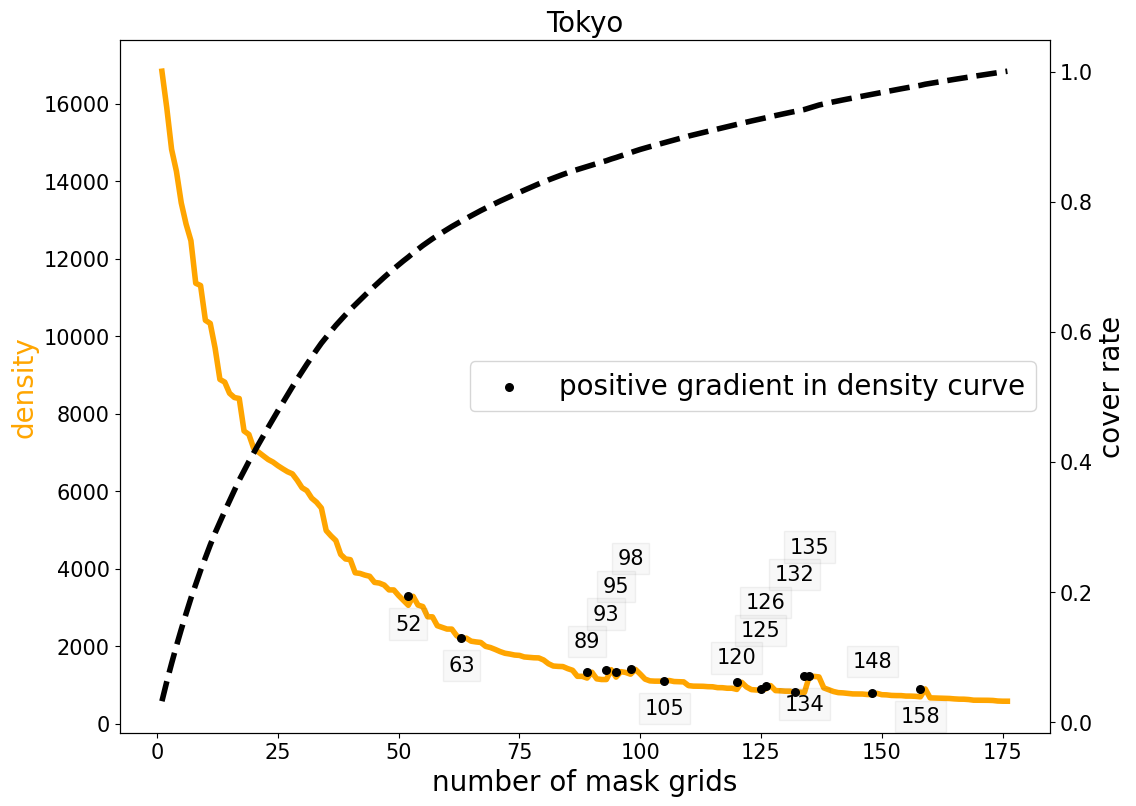

In [562]:
#print(density_trace)
xrange = np.arange(1, len(density_trace)+1)

density_trace = save_dict['added_density']
cover_trace = save_dict['cover_rate']

back_index = []
for i in (xrange[:-1]):
    if density_trace[i] > density_trace[i-1]:
        back_index.append(i)
print(back_index)
back_density = [density_trace[b] for b in back_index]

plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(figsize=(12, 9))

ax1.plot(xrange, density_trace, linewidth='4', color='orange')
ax1.scatter(back_index, back_density, color='black', s=30, label='positive gradient in density curve', zorder=2)
ax1.set_xlabel('number of mask grids', fontsize='20')
ax1.set_ylabel('density', color='orange', fontsize='20')
ax1.legend(loc='right', fontsize='20')

txt_height = 0.04 * (plt.ylim()[1] - plt.ylim()[0])
txt_width = 0.03 * (plt.xlim()[1] - plt.xlim()[0])
text_positions = get_text_positions(back_index, back_density, txt_width, txt_height)
for xi, yi in zip(back_index, text_positions):
    ax1.text(xi, yi, xi, ha='center', va='center', bbox=dict(facecolor='gray', alpha=0.05))

ax2 = ax1.twinx()
ax2.plot(xrange, cover_trace, linestyle='--', linewidth='4', color='black', zorder= 0.5)
ax2.set_ylabel('cover rate', color='black', fontsize='20')
plt.title('Tokyo', fontsize='20')
plt.show()

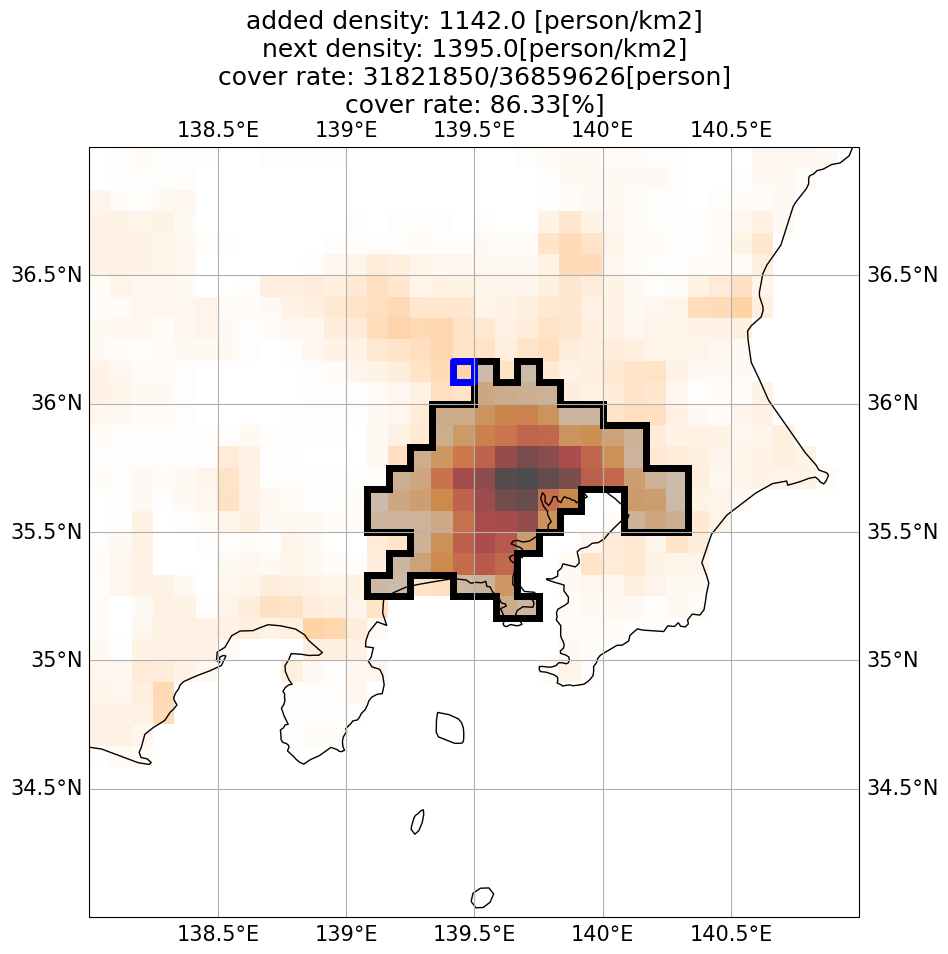

In [565]:
mask_num = 93
city_index = 1

bestmask_trace = save_dict['mask']
density_trace = save_dict['added_density']
nextdensity_trace = save_dict['next_density']
totalpop_trace = save_dict['masked_population']
coverage_trace = save_dict['cover_rate']
nextcoords_trace = save_dict['next_coords']
un_pop = save_dict['un_population']
gwp_pop_density = save_dict['population_density']

mask_tmp = bestmask_trace[:, :, mask_num-1]
prv = density_trace[mask_num-1]
nxt = nextdensity_trace[mask_num-1]
pop = totalpop_trace[mask_num-1]
cov = coverage_trace[mask_num-1]
cor = nextcoords_trace[mask_num-1]

draw_mask(mask_tmp, gwp_pop_density, city_index, np.round(prv), np.round(nxt), pop, un_pop, cov, cor)

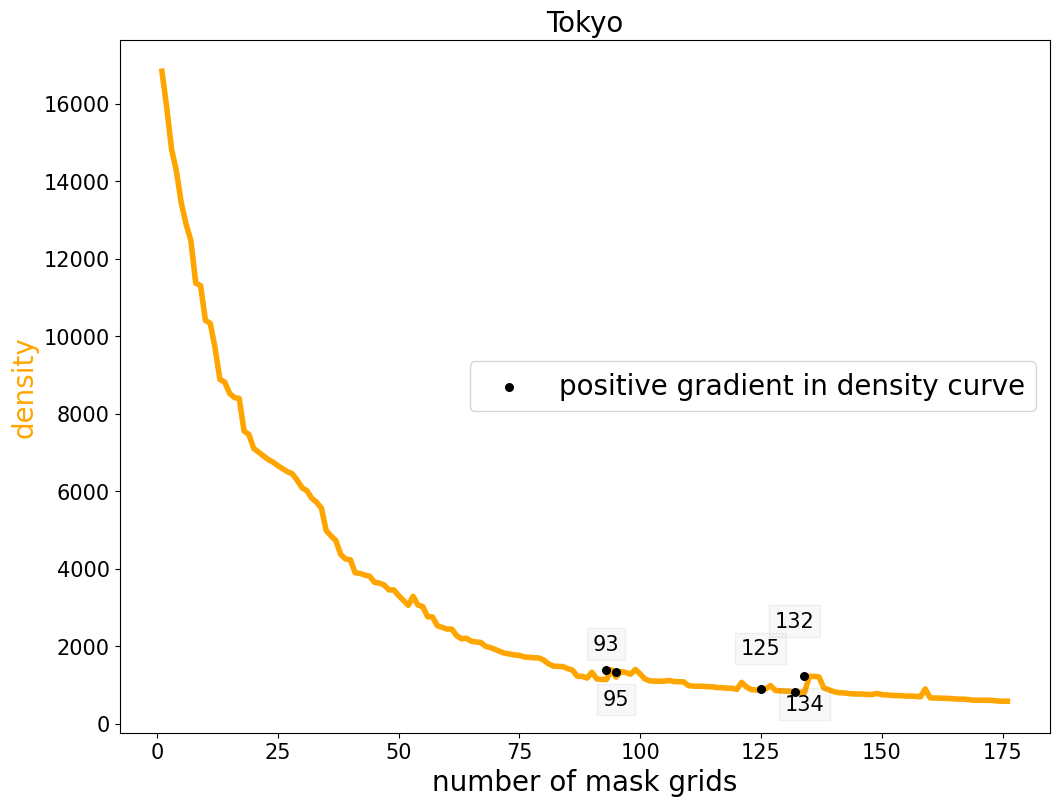

In [563]:
#print(density_trace)
xrange = np.arange(1, len(density_trace)+1)

density_trace = save_dict['added_density']

back_index = []
for i in (xrange[:-1]):
    if density_trace[i] > density_trace[i-1]:
        back_index.append(i)

check_range = 3
valid_index = []
for i in range(len(back_index)-1):
    gap = back_index[i+1] - back_index[i]
    if gap <= check_range:
        valid_index.append(back_index[i])

valid_density = [density_trace[v] for v in valid_index]

plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(figsize=(12, 9))

ax1.plot(xrange, density_trace, linewidth='4', color='orange')
ax1.scatter(valid_index, valid_density, color='black', s=30, label='positive gradient in density curve', zorder=2)
ax1.set_xlabel('number of mask grids', fontsize='20')
ax1.set_ylabel('density', color='orange', fontsize='20')
ax1.legend(loc='right', fontsize='20')

txt_height = 0.04 * (plt.ylim()[1] - plt.ylim()[0])
txt_width = 0.03 * (plt.xlim()[1] - plt.xlim()[0])
text_positions = get_text_positions(valid_index, valid_density, txt_width, txt_height)
for xi, yi in zip(valid_index, text_positions):
    ax1.text(xi, yi, xi, ha='center', va='center', bbox=dict(facecolor='gray', alpha=0.05))

plt.title('Tokyo', fontsize='20')
plt.show()

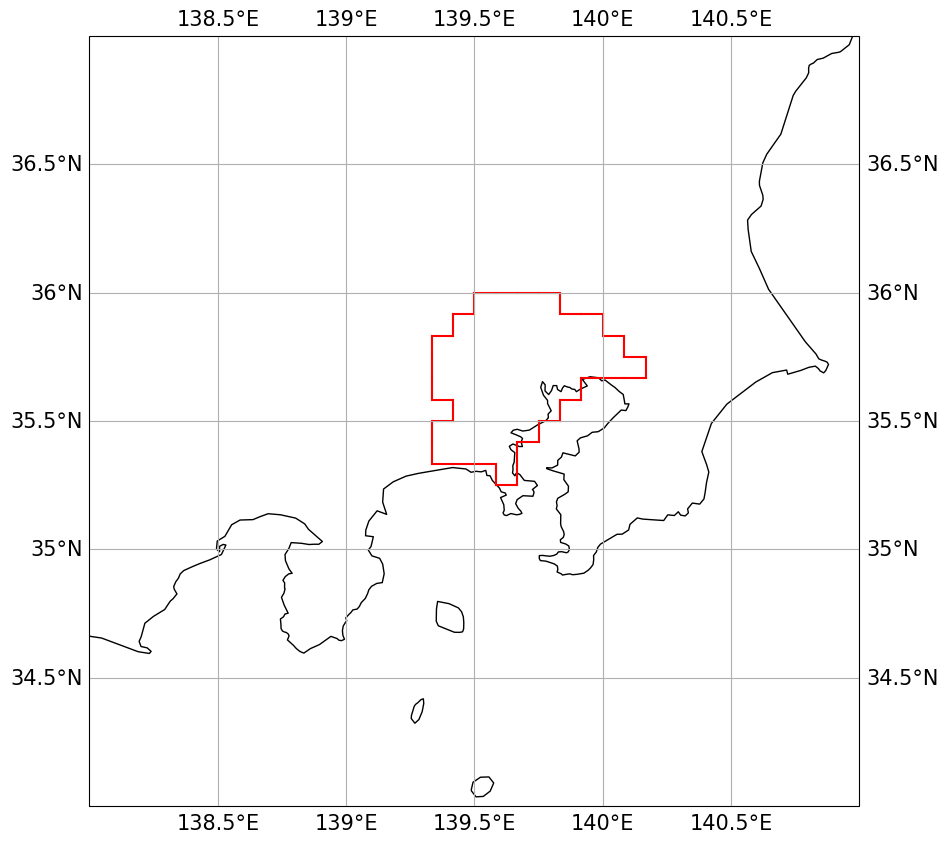

In [459]:
import numpy as np
import matplotlib.pyplot as plt

projection = ccrs.PlateCarree()

# figure
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.set_extent(img_extent)
ax.gridlines(draw_labels=True)

mask_temp = bestmask_trace[:, :, mask_num-1]
a, b, upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent, city_num = geography()
#print(img_extent) # 138, 141, 34, 37
raster_data = mask_temp[upperindex:lowerindex, leftindex:rightindex]

# outer
upper_indices = []
lower_indices = []
left_indices = []
right_indices = []
rows, cols = raster_data.shape
for i in range(rows):
    for j in range(cols):
        if raster_data[i, j] == 1:
            if raster_data[i-1, j] == 0:
                upper_indices.append((i, j))
            if raster_data[i+1, j] == 0:
                lower_indices.append((i, j))
            if raster_data[i, j-1] == 0:
                left_indices.append((i, j))
            if raster_data[i, j+1] == 0:
                right_indices.append((i, j))
                
delta = 360/4320
x_left = img_extent[0]
y_top = img_extent[3]

for up in upper_indices:
    x_index = x_left + delta*(up[1])
    y_index = y_top - delta*(up[0])
    ax.plot([x_index, x_index+delta], [y_index, y_index], color='red', transform=ccrs.PlateCarree()) # right
for lo in lower_indices:
    x_index = x_left + delta*(lo[1])
    y_index = y_top - delta*(lo[0]+1)
    ax.plot([x_index, x_index+delta], [y_index, y_index], color='red', transform=ccrs.PlateCarree()) # right
for le in left_indices:
    x_index = x_left + delta*(le[1])
    y_index = y_top - delta*(le[0]+1)
    ax.plot([x_index, x_index], [y_index, y_index+delta], color='red', transform=ccrs.PlateCarree()) # right
for ri in right_indices:
    x_index = x_left + delta*(ri[1]+1)
    y_index = y_top - delta*(ri[0]+1)
    ax.plot([x_index, x_index], [y_index, y_index+delta], color='red', transform=ccrs.PlateCarree()) # right
    

# plot raster
seethrough = np.ma.masked_where(raster_data == 0, raster_data)
seethrough[-1, -1] = 0
citymask_cmap = plt.cm.colors.ListedColormap(['white', '#999999'])
im2 = ax.imshow(seethrough, origin='upper',extent=img_extent, transform=projection, cmap=citymask_cmap)

plt.show()